In [8]:
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from keras.utils import to_categorical
from keras.preprocessing.image import array_to_img
from keras.applications.resnet50 import ResNet50
from keras.models import Model,load_model
from keras.layers import Dense, Flatten
from IPython.display import display,clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt 
%matplotlib inline

# Housekeeping variables

In [33]:
label_meaning = {'c0': 'safe driving', 'c1':'texting - right', 'c2':'talking on the phone - right',
                'c3':'texting - left', 'c4':'talking on the phone - left', 'c5':'operating the radio',
                'c6':'drinking', 'c7':'reaching behind','c8':'hair and makeup', 'c9':'talking to passenger'}
train_path = '/home/minheng/train'
test_path = '/home/minheng/test'

# convert image into numpy array

In [2]:
data = np.empty((22424,480,640,3), dtype = np.uint8 )

label = np.empty(22424, dtype = np.uint8)

def load_data(path):
    i = 0
    for name in os.listdir(path):
        rank = int(name[1])
        file_path = os.path.join(path,name)
        for pic in os.listdir(file_path):
            pic_name = os.path.join(file_path, pic)
            data[i] = np.array(Image.open(pic_name),dtype = np.uint8)
            label[i] = rank
            i += 1
            
load_data(train_path)

# Save/Load the data

In [2]:
#np.save('train_data', data)
data = np.load('train_data.npy')

In [3]:
#np.save('train_label', label)
label = np.load('train_label.npy')

# use 1000 samples for base case testing

In [3]:
slicer = np.random.randint(0, high = 22424, size = 1000)

x = data[slicer]

x = x.reshape(x.shape[0], -1)

y = label[slicer]

# train_test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# fit model (base model : KNN)

In [10]:
neighbor = KNeighborsClassifier(n_neighbors=5)
neighbor.fit(X_train, y_train)
neighbor.score(X_test,y_test)

0.65500000000000003

# One hot encode labels

In [4]:
label = to_categorical(label)

# load pre-train model(res50) and add a dense layer 

In [42]:
model = ResNet50(include_top=False,input_shape= (480,640,3))

fc = model.get_layer('avg_pool').output
f = Flatten()(fc)
p = Dense(units= 10, activation='softmax')(f)
final = Model(inputs = model.input, outputs = p)

for layers in final.layers[:-1]:
    layers.trainable = False
    
final.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Train the new model

In [62]:
final.fit(data,label,epochs=2,validation_split=0.25)

Train on 17939 samples, validate on 4485 samples
Epoch 1/2
17939/17939 [==============================] - 1435s - loss: 0.3613 - acc: 0.9064 - val_loss: 0.0703 - val_acc: 0.9871
Epoch 2/2
17939/17939 [==============================] - 1433s - loss: 0.0458 - acc: 0.9918 - val_loss: 0.0341 - val_acc: 0.9938


# save/load the model

In [3]:
#final.save('my_model.h5')
model = load_model('my_model.h5')

# The model seems to be fitting very well on the validation set. Let's see how it perform on the real testing sets

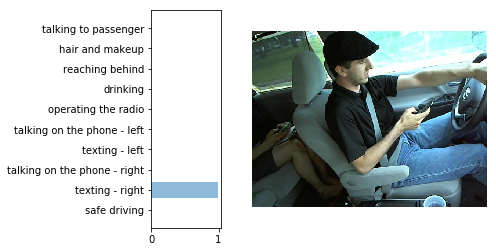

In [119]:
def show(picture_path):
    pic = Image.open(picture_path)
    pred = model.predict(np.expand_dims(np.array(pic), axis = 0))
    t = np.arange(0, 10, 1)
    f, (ax1, ax2) = plt.subplots(1, 2,gridspec_kw = {'width_ratios':[3, 10]})
    ax2.imshow(pic)
    ax2.axis('off')
    ax1.barh(t, pred[0] ,align = 'center', alpha = 0.5)
    ax1.set_yticks(t)
    ax1.set_yticklabels(y_lab)

y_lab = [i[1] for i in label_meaning.items()]
inputbox = widgets.Text(description = 'WHICH PICTURE')
display(inputbox)  

def choose_pic(sender):
    clear_output()
    n = os.listdir(test_path)
    s = int(inputbox.value)
    if s <= len(n) and s > 0:
        pictures = np.array([os.path.join(test_path, i) for i in n])[s]
    else:
        pictures = np.array([os.path.join(test_path, i) for i in n])[0]
    show(pictures)
    
inputbox.on_submit(choose_pic)